In [1]:
# installing necessary dependancies to run the project

!pip install scikit-learn opencv-python numpy matplotlib tqdm --user
import os
import glob
import cv2
from matplotlib import pyplot as plt
import numpy as np

You should consider upgrading via the 'c:\users\khushalpt\anaconda33\python.exe -m pip install --upgrade pip' command.


The face images of different persons are stored in the following directory.

In [2]:
# reading local repository
DATASET = 'data/webapp'

We read the dataset and visualize some images. We discard the persons which have less than 50 face images to reduce noise and variance.

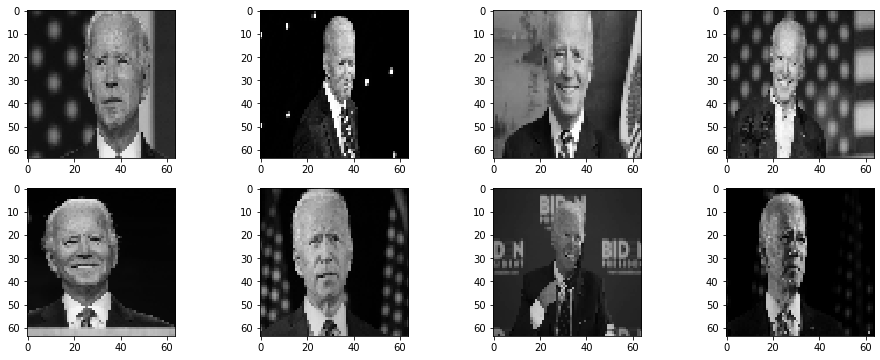

Read 33 images of 4 persons 


In [3]:
# preprocessing the images that include resizing, grey scale and reading the images and labels into arrays

n_imgs = 35
width = height = 64

lfw_imgs = np.zeros((n_imgs, width, height, ), dtype=np.float32)
lfw_labels = np.zeros((n_imgs, ))
fig = plt.figure(figsize=(16, 6))
i = 1
unique_labels = {}
id_to_name = {}
c = 0
for root, dirs, files in os.walk(DATASET):
    for file in files:
        if file.endswith(".jpg") and len(os.listdir(root))>0:
            img_path = os.path.join(root, file)
            img = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY), (width, height))
            label = root.split('/')[-1]
            if label not in unique_labels:
                unique_labels[label] = c
                id_to_name[c] = label
                c+=1
            lfw_imgs[i-1] = np.array(img)
            lfw_labels[i-1] = unique_labels[label]
            if i<=8:
                plt.subplot(2, 4, i)
                plt.imshow(img, cmap='gray', vmin=0, vmax=255) 
            i+=1
plt.show()
print ("Read %s images of %s persons "%(i-1,c))

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(lfw_imgs, lfw_labels, test_size=0.2, random_state=42)

X_train = X_train.reshape(-1,width*height)
X_test = X_test.reshape(-1,width*height)

## LDA and SVD Combination

In [5]:
from sklearn.decomposition import TruncatedSVD
svdmodel = TruncatedSVD(n_components=128, random_state=0)
X_train_svd = svdmodel.fit_transform(X_train)
X_test_svd = svdmodel.transform(X_test)

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
ldamodel = LinearDiscriminantAnalysis()
X_train_lda = ldamodel.fit_transform(np.concatenate((X_train, X_train_svd), axis=1), y_train)

In [7]:
# Evaluation of the model
y_pred = ldamodel.predict(np.concatenate((X_test, X_test_svd), axis=1))

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
print(classification_report(y_test, y_pred, ))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.00      0.00      0.00         1
         2.0       1.00      0.50      0.67         2
         3.0       0.00      0.00      0.00         4

    accuracy                           0.14         7
   macro avg       0.25      0.12      0.17         7
weighted avg       0.29      0.14      0.19         7



C:\Users\khushalpt\anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\khushalpt\anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**LDA and PCA Combination**

In [9]:
from sklearn.decomposition import PCA
n_components = 8
print("Extracting the top {} eigenfaces from {} faces".format(n_components, X_train.shape[0]))
pca = PCA(n_components=n_components, whiten=True).fit(X_train)

# Transform data into principal components representation
print("Transforming the test data using the the orthonormal basis of PCA")
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Extracting the top 8 eigenfaces from 28 faces
Transforming the test data using the the orthonormal basis of PCA


In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis()
X_train_lda = model.fit_transform(np.concatenate((X_train, X_train_pca), axis=1), y_train)

In [11]:
# Evaluation of the model
y_pred = model.predict(np.concatenate((X_test, X_test_pca), axis=1))

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
print(classification_report(y_test, y_pred, ))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.50      1.00      0.67         2
         3.0       1.00      0.75      0.86         4

    accuracy                           0.71         7
   macro avg       0.50      0.58      0.51         7
weighted avg       0.71      0.71      0.68         7



C:\Users\khushalpt\anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Face Recognition using Webcam

In [ ]:
import sys
from IPython.display import display, clear_output
def show_webcam():
    cam = cv2.VideoCapture(0)
    while True:
        ret_val, img = cam.read()
        img = cv2.flip(img, 1)
        cv2.imshow('my webcam', img)
        if cv2.waitKey(1) == 27: 
            break  # esc to quit
        img = np.array(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (width, height)))
        img = img.reshape(-1, width*height)
        img_svd = svdmodel.transform(img)
        y_pred = ldamodel.predict(np.concatenate((img, img_svd), axis=1))
        clear_output(wait=True)
        display(id_to_name[int(y_pred)])
    cv2.destroyAllWindows()


show_webcam()


'webapp\\Khushal'